Lettuce Growth Detection

Data Augmentation

In [15]:
%pip install tensorflow keras numpy pandas matplotlib scikit-learn

^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Library

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
from albumentations import (
    HorizontalFlip, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur, 
    Rotate, CLAHE, RGBShift, HueSaturationValue, OneOf
)
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
base_dir = 'data/'  # Base folder containing week_1 to week_7
train_dir = os.path.join(base_dir, 'train/')
val_dir = os.path.join(base_dir, 'val/')
test_dir = os.path.join(base_dir, 'test/')

Data Preparation

In [9]:



def clear_and_create_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Delete folder and its contents
    os.makedirs(directory)  # Recreate the empty folder


# Clear and recreate train, val, and test directories
clear_and_create_directory(train_dir)
clear_and_create_directory(val_dir)
clear_and_create_directory(test_dir)

# Create directories if they don’t exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to copy files to target directory
def copy_files(file_paths, label, target_dir):
    label_dir = os.path.join(target_dir, str(label))  # e.g., train/0, train/1
    os.makedirs(label_dir, exist_ok=True)
    for path in file_paths:
        shutil.copy(path, label_dir)

# Function to augment and save images
def augment_and_save(images, label_dir, augmentations, multiplier=5):
    for image_path in images:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        base_name = Path(image_path).stem

        for i in range(multiplier):  # Generate 'multiplier' augmented versions
            augmented = augmentations(image=img)['image']
            augmented_path = os.path.join(label_dir, f"{base_name}_aug_{i}.jpg")
            cv2.imwrite(augmented_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

# Define more complex augmentations using albumentations
augmentations = OneOf([
    HorizontalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
    RandomBrightnessContrast(p=0.2),
    GaussianBlur(blur_limit=(3, 7), p=0.2),
    Rotate(limit=45, p=0.5),  # Random rotations
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),  # Contrast Limited Adaptive Histogram Equalization
    RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.5),  # Random color shift
    HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5)  # Hue, Saturation, Value adjustments
], p=1.0)

# Loop through each class (week_1 to week_7)
for week in range(1, 8):
    week_folder = os.path.join(base_dir, f"week_{week}")
    if os.path.exists(week_folder):
        images = [os.path.join(week_folder, img) for img in os.listdir(week_folder) if img.lower().endswith(('.jpg', '.png'))]
        label = week - 1  # Convert week_1 to label 0, week_2 to label 1, etc.

        # Split class-wise: 80% train, 10% val, 10% test
        train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

        # Copy files to respective directories
        copy_files(train_images, label, train_dir)
        copy_files(val_images, label, val_dir)
        copy_files(test_images, label, test_dir)

        # Perform data augmentation for the training dataset
        label_dir = os.path.join(train_dir, str(label))
        augment_and_save(train_images, label_dir, augmentations, multiplier=10)  # 10 augmentations per image

# Print summary
print("Data preparation and augmentation complete!")
print(f"Training folder contents: {sorted(os.listdir(train_dir))}")
print(f"Validation folder contents: {sorted(os.listdir(val_dir))}")
print(f"Test folder contents: {sorted(os.listdir(test_dir))}")

Data preparation and augmentation complete!
Training folder contents: ['0', '1', '2', '3', '4', '5', '6']
Validation folder contents: ['0', '1', '2', '3', '4', '5', '6']
Test folder contents: ['0', '1', '2', '3', '4', '5', '6']


Data Generation

In [10]:
# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Prepare the data generators
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Debugging class labels
print("Training classes:", train_data.class_indices)
print("Validation classes:", val_data.class_indices)

Found 803 images belonging to 7 classes.
Found 10 images belonging to 7 classes.
Found 13 images belonging to 7 classes.
Training classes: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}
Validation classes: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}


Model Training

In [11]:
# Ensure output layer matches the number of classes
num_classes = len(train_data.class_indices)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')  # Adjusted to match the dataset
])
# early_stopping = EarlyStopping(
#     monitor='val_loss',   # Monitor the validation loss
#     patience=3,           # Number of epochs with no improvement after which training will stop
#     restore_best_weights=True,  # Restore the best weights once training is stopped
#     verbose=1              # Print a message when early stopping is triggered
# )
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    # callbacks=[early_stopping] 
)




Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.1895 - loss: 14.0890 - val_accuracy: 0.2000 - val_loss: 1.9696
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.2474 - loss: 1.8322 - val_accuracy: 0.2000 - val_loss: 1.8273
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.2842 - loss: 1.7251 - val_accuracy: 0.4000 - val_loss: 1.6005
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.4331 - loss: 1.5279 - val_accuracy: 0.5000 - val_loss: 1.3430
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.4831 - loss: 1.3454 - val_accuracy: 0.9000 - val_loss: 0.7613
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.5696 - loss: 1.1298 - val_accuracy: 1.0000 - val_loss: 0.6809
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.6276 - loss: 1.0180 - val_accuracy: 0.8000 - val_loss: 0.8132
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.6237 - loss: 1.0032 - val_accuracy: 0.9000 - val_los

Save Model

In [12]:

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the trained model
model.save('lettuce_growth_model.keras')
print("Model training complete!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0456
Test Accuracy: 1.00
Model training complete!


evaluation

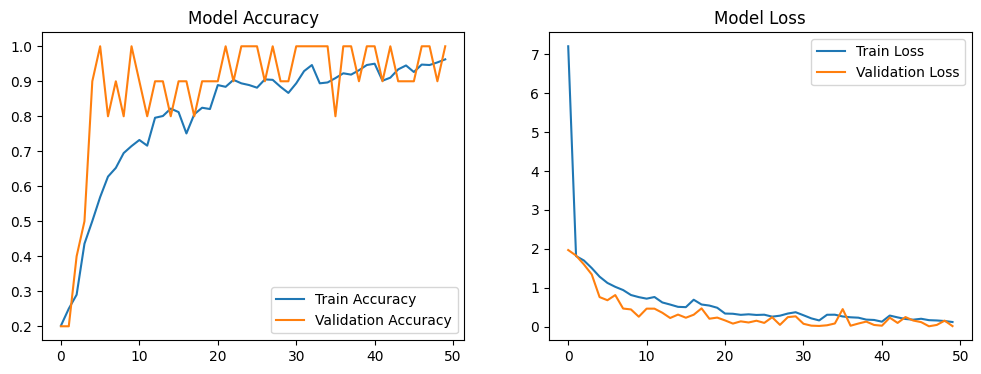

In [14]:

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()
